In [45]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json
import requests
import urllib.request
from tqdm import tqdm
# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import nibabel as nib

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image
from scipy.io import loadmat

def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)

from nilearn import image
from nilearn.plotting import plot_prob_atlas
%matplotlib inline
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from nilearn.decomposition import CanICA

#Make function for everything 

def spatial_ICA(func_path, anat_path, ica_comp, pca = True, pca_comp = None,  axial_plots = True, other_plots = False, filename = "plot"): 

    img = nib.load(func_path)
    affine = img.affine
    fdata = img.get_fdata()
    x, y, z, N_vol = fdata.shape
    display("Got fdata of dimensions =", x, y, z, N_vol)
    
    X_ = fdata.reshape(-1, fdata.shape[-1])
    X = X_.T
    display("X shape =", X.shape)
    
    T1w_img = nib.load(anat_path)
    skull = nib.load("skull.nii.gz")
    masker = NiftiMasker(mask_img=skull)
    #plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)
    
    S_dict = {}

    nb_components =  [ica_comp,]#10]#20, 60 ...]
    
    
    for n in nb_components:

        if (pca):
            print(f"Processing component {n}")
            # run PCA as a preprocessing step for ICA with twice the number of components
            n2=2*n

            if (pca_comp is not None):
                n2 = pca_comp
            pca = PCA(n_components=n2)
            H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
            display(pca.explained_variance_ratio_, "Explained Variance = ", np.sum(pca.explained_variance_ratio_))
        else:
            H = X.T
        
        display("Running FastICA with n = %d components" %n)

        ica = FastICA(n_components=n, random_state=1, max_iter=200)
        display("size H", H.shape)
        S_ = ica.fit_transform(H)  # Get the estimated sources (S)
        display("size S", S_.shape)
        print(S_.shape)
        W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
        S_dict[n] = S_ # store the results in a dictionary
    
    display("Done ICA")

    if (axial_plots):
        for n in nb_components:
            print('Number of components: ', n)
            S_ = S_dict[n].copy()
            for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
                s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
                data = masker.fit_transform(s_img)
                masked_ = masker.inverse_transform(data) #mask the components
                plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                              colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img)
                              #output_file=filename + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
                plt.show()

    if (other_plots):
        #* Plot the group-level independent components for the different number of requested components.
        for n in nb_components:
            print('Number of components: ', n)
            S_ = S_dict[n].copy()
            for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
                s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
                data = masker.fit_transform(s_img)
                masked_ = masker.inverse_transform(data) # mask the components
                plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                              colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img,)
                              #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
                plt.show()
    display("Done all")
    return S_dict

class groupICA:
    def fit_data(self, func_expl, func_folder_path, anat_path, skull, N_subj = 10):
        
        
        img = nib.load(func_expl)
        affine = img.affine
        fdata = img.get_fdata()
        x, y, z, N_vol = fdata.shape
        N_tot=N_vol*N_subj
        
        display("dims =", x,y,z, N_vol)

        X = np.zeros((N_tot,x*y*z))
        nii_count = 0
        for root, dirs, files in sorted(os.walk(func_folder_path)):
            if (files and 'bold' in files[0]):
                if (nii_count < N_subj):
                    display("nii_count:", nii_count)
                    func_fdata = nib.load(root + '/' + files[0]).get_fdata()
                    
                    subject_X = func_fdata.reshape(-1, fdata.shape[-1]).T
                    #subject_X = zscore(subject_X, axis = None)
                    
                    X[nii_count * N_vol:(nii_count + 1) * N_vol, :] = subject_X
                    nii_count += 1
        
        self.X = np.nan_to_num(X,0)
        self.anat_path = anat_path
        self.dims = x, y, z, N_vol, N_tot
        self.affine = affine
        self.skull = skull
        
        display("X shape =", X.shape)
        return 0

    def execute(self, ica_comp, pca = True, pca_comp = None, axial_plots = True, other_plots = False, type = "spatial"):
        
    
        T1w_img = nib.load(self.anat_path)
        x, y, z, N_vol, _ = self.dims

        masker = NiftiMasker(mask_img=self.skull)
        plot_stat_map(self.skull, black_bg=True, title='the brain mask', colorbar=False,)
    
        S_dict = {}

        nb_components =  [ica_comp,]#10]#20, 60 ...]
        
        if (type == "temporal"):
            self.X = self.X.T
            
        for n in nb_components:

            if (pca):
                print(f"Processing component {n}")
                # run PCA as a preprocessing step for ICA with twice the number of components
                n2=2*n

                if (pca_comp is not None):
                    n2 = pca_comp
                    
                pca = PCA(n_components=n2)
                H = pca.fit_transform(self.X.T)  # Reconstruct signals based on orthogonal components
                display(pca.explained_variance_ratio_, "Explained Variance = ", np.sum(pca.explained_variance_ratio_))
            else:
                H = self.X.T
        
            display("Running FastICA with n = %d components" %n)
            ica = FastICA(n_components=n, random_state=1, max_iter=200)
            display("size H", H.shape)
            S_ = ica.fit_transform(H)  # Get the estimated sources (S)
            display("size S", S_.shape)
            print(S_.shape)
            #W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
            S_dict[n] = S_ # store the results in a dictionary
    
        display("Done ICA")
    
        if (axial_plots):
            for n in nb_components:
                print('Number of components: ', n)
                S_ = S_dict[n].copy()
                for idx, s in enumerate(S_.T[:min(20, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
                    s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), self.affine)
                    data = masker.fit_transform(s_img)
                    masked_ = masker.inverse_transform(data) #mask the components
                    plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                                  colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img)
                                  #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
                    plt.show()
    
        if (other_plots):
            #* Plot the group-level independent components for the different number of requested components.
            for n in nb_components:
                print('Number of components: ', n)
                S_ = S_dict[n].copy()
                for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
                    s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), self.affine)
                    data = masker.fit_transform(s_img)
                    masked_ = masker.inverse_transform(data) # mask the components
                    plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                                  colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=T1w_img)
                                  #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
                    plt.show()
        display("Done all")
        return S_dict

# MINI PROJECT 2
## Variant 3

In [46]:
bids_root = op.join(os.path.abspath(""))
print(bids_root)

func_name = f"sub-04_task-watchmovie_bold.nii.gz"
anat_name = "sub-04_T1w.nii.gz"

img = nib.load(func_name)
affine = img.affine
fdata = img.get_fdata()
x, y, z, N_vol = fdata.shape

### 1. Briefly describe the dataset and the scientific question you want to answer.

### 2.

### 3. Vary the number of components you are considering and visualise the spatial maps. Check if you are able to find meaningful maps according to the question you asked or the type of the dataset. You can also look at the atlas to have hints on the brain regions of interest.

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

array([9.99968829e-01, 3.39776795e-06, 1.76236724e-06, 1.56847129e-06,
       1.40762376e-06, 1.06679638e-06, 9.97099209e-07, 8.92371295e-07])

'Explained Variance = '

0.9999799218607478

'Running FastICA with n = 4 components'

'size H'

(271633, 8)

'size S'

(271633, 4)

'Done ICA'

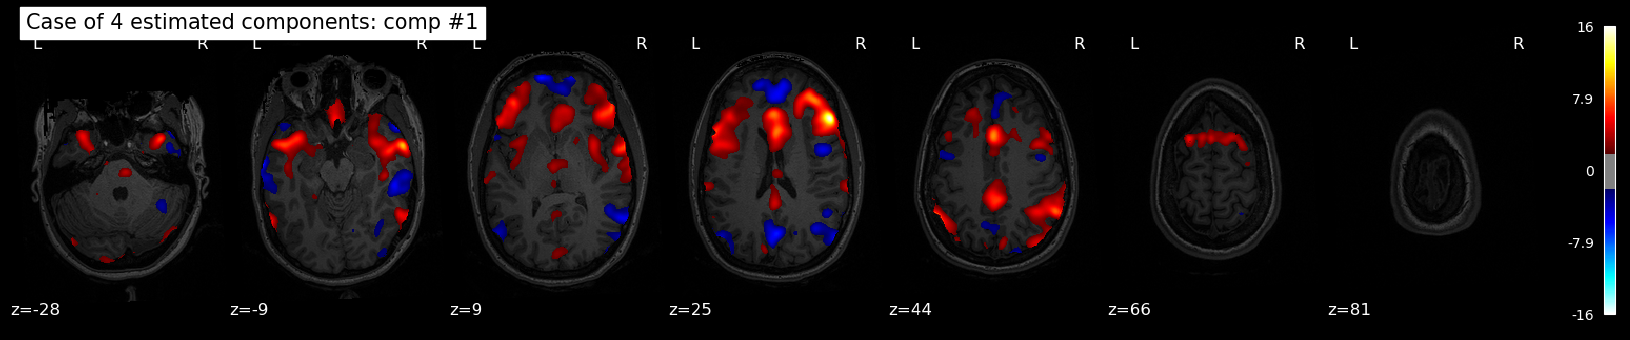

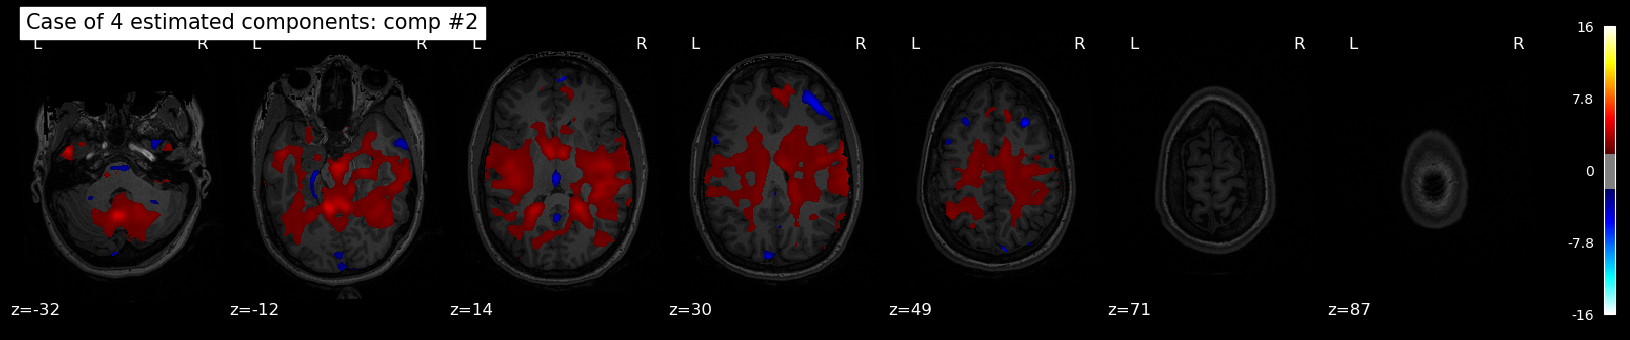

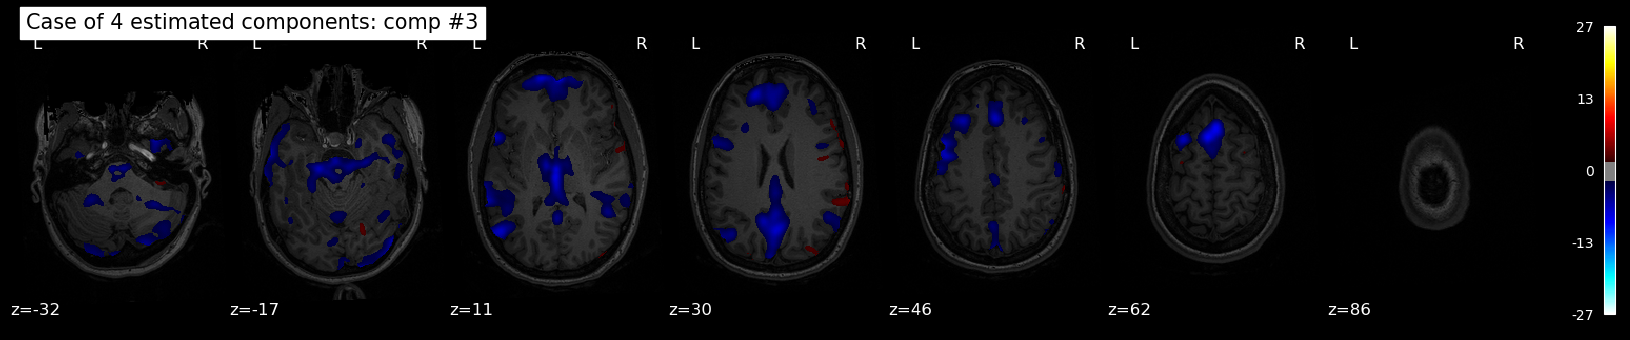

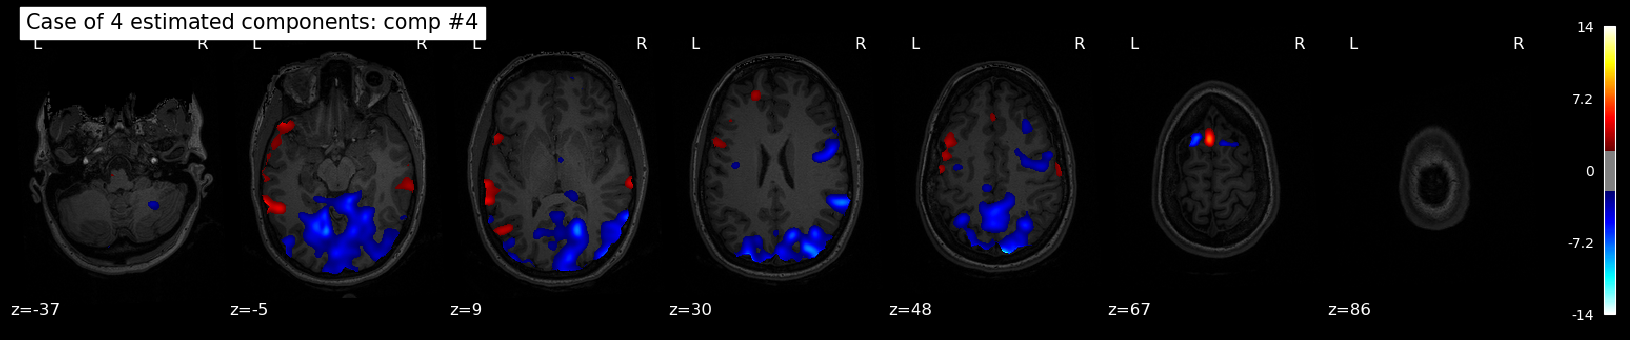

'Done all'

{4: array([[-0.21157581, -0.32531583,  0.35058664,  0.26328716],
        [-0.21157566, -0.32531623,  0.35058632,  0.26328707],
        [-0.21157566, -0.32531623,  0.35058632,  0.26328707],
        ...,
        [-0.21157566, -0.32531623,  0.35058632,  0.26328707],
        [-0.21157566, -0.32531623,  0.35058632,  0.26328707],
        [-0.21157566, -0.32531623,  0.35058632,  0.26328707]])}

In [47]:
spatial_ICA(func_path = func_name, anat_path = anat_name, ica_comp = 4, pca = True, filename = "first_4")

In [4]:
spatial_ICA(func_path = func_name, anat_path = anat_name, ica_comp = 8, filename = "first_8")

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

array([9.99968829e-01, 3.39776795e-06, 1.76236724e-06, 1.56847129e-06,
       1.40762376e-06, 1.06679639e-06, 9.97099267e-07, 8.92373021e-07,
       8.03246962e-07, 6.85793842e-07, 6.71793681e-07, 6.10027169e-07,
       5.41233163e-07, 5.41123299e-07, 4.76073765e-07, 4.51983748e-07])

'Explained Variance = '

0.9999847031381759

'Running FastICA with n = 8 components'

'size H'

(271633, 16)

'size S'

(271633, 8)

'Done ICA'

'Done all'

{8: array([[ 0.18275974, -0.25669101, -0.07403406, ..., -0.25317972,
         -0.29425237, -0.0989612 ],
        [ 0.18275973, -0.25669105, -0.0740342 , ..., -0.25317974,
         -0.29425228, -0.09896108],
        [ 0.18275973, -0.25669105, -0.0740342 , ..., -0.25317974,
         -0.29425228, -0.09896108],
        ...,
        [ 0.18275973, -0.25669105, -0.0740342 , ..., -0.25317974,
         -0.29425228, -0.09896108],
        [ 0.18275973, -0.25669105, -0.0740342 , ..., -0.25317974,
         -0.29425228, -0.09896108],
        [ 0.18275973, -0.25669105, -0.0740342 , ..., -0.25317974,
         -0.29425228, -0.09896108]])}

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

array([9.99968829e-01, 3.39776795e-06, 1.76236724e-06, 1.56847129e-06,
       1.40762376e-06, 1.06679639e-06, 9.97099267e-07, 8.92373021e-07,
       8.03246963e-07, 6.85793863e-07, 6.71793718e-07, 6.10027516e-07,
       5.41233462e-07, 5.41123392e-07, 4.76076848e-07, 4.51988314e-07,
       4.09494259e-07, 3.72931446e-07, 3.44926368e-07, 3.24817912e-07,
       2.83885191e-07, 2.66627824e-07, 2.55540864e-07, 2.41049606e-07,
       2.23643188e-07, 2.13110995e-07, 2.05213816e-07, 1.93650357e-07,
       1.86949369e-07, 1.80854216e-07, 1.76958004e-07, 1.71715849e-07,
       1.62068900e-07, 1.55702576e-07, 1.47935259e-07, 1.36825005e-07,
       1.28442830e-07, 1.23314835e-07, 1.19434091e-07, 1.17389515e-07])

'Explained Variance = '

0.9999898456288967

'Running FastICA with n = 20 components'

'size H'

(271633, 40)

'size S'

(271633, 20)

'Done ICA'

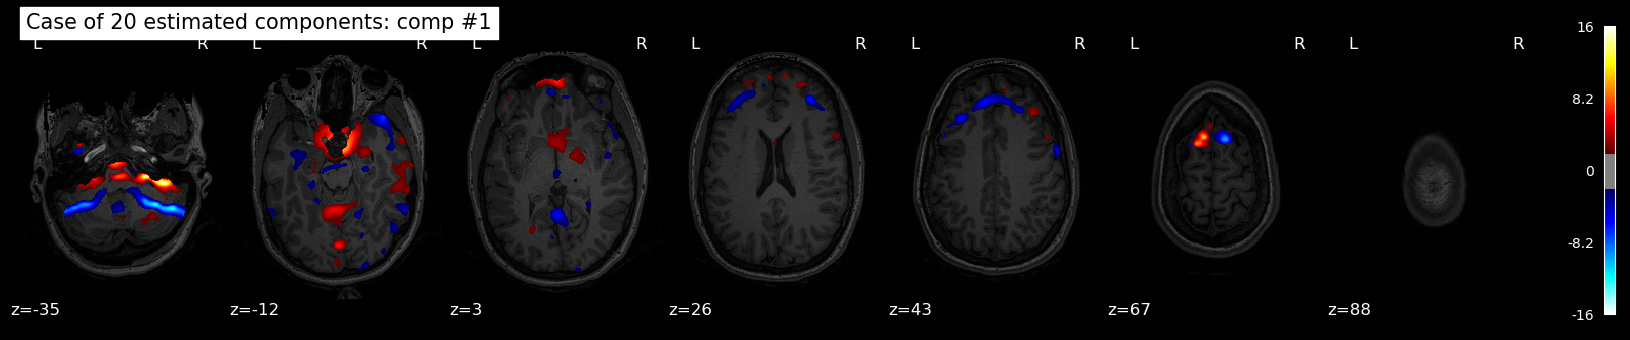

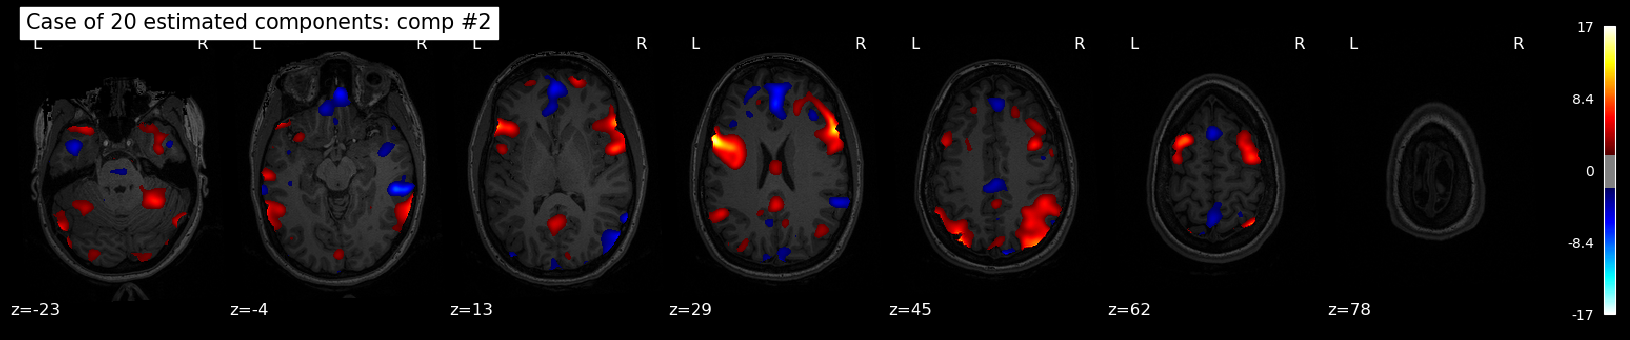

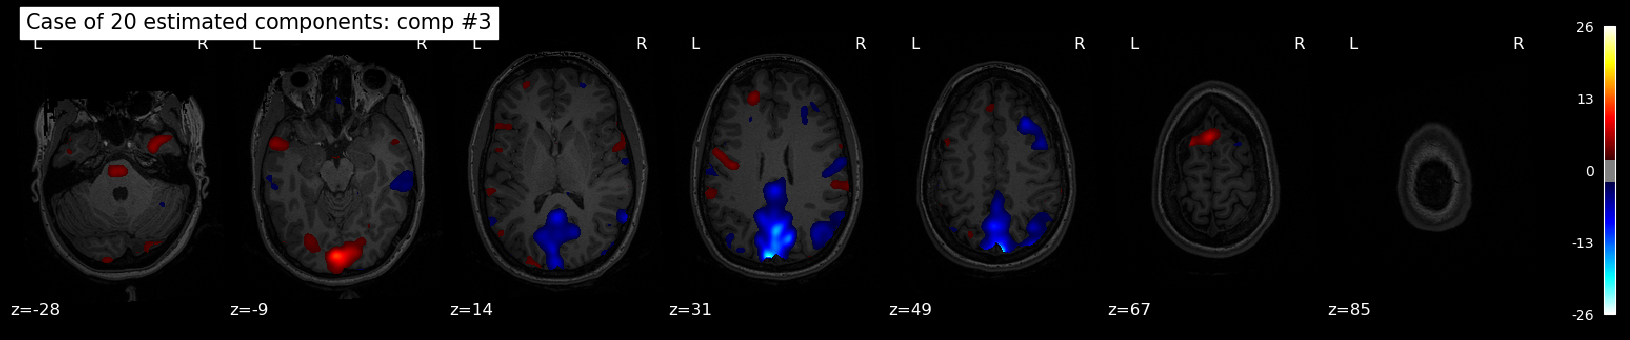

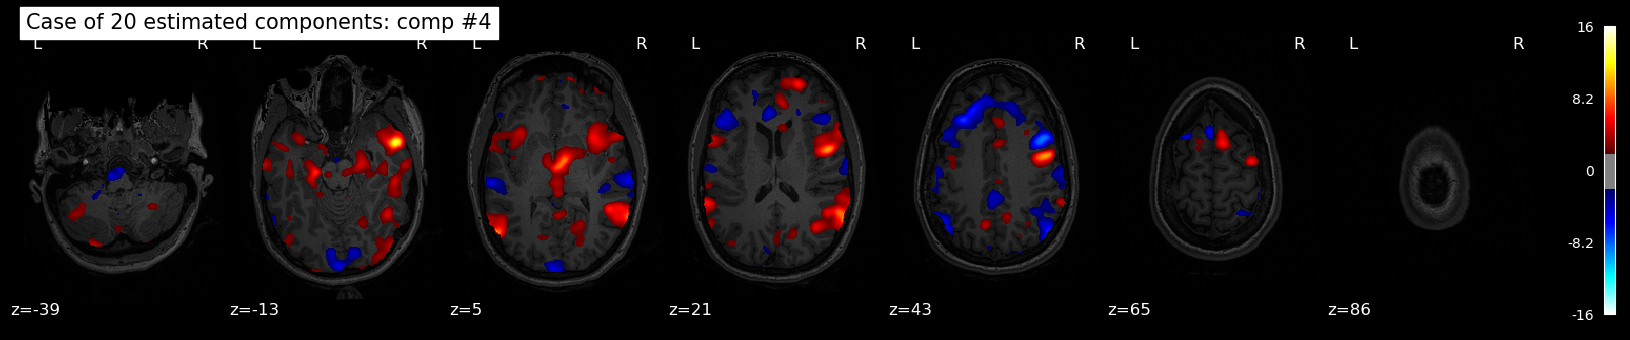

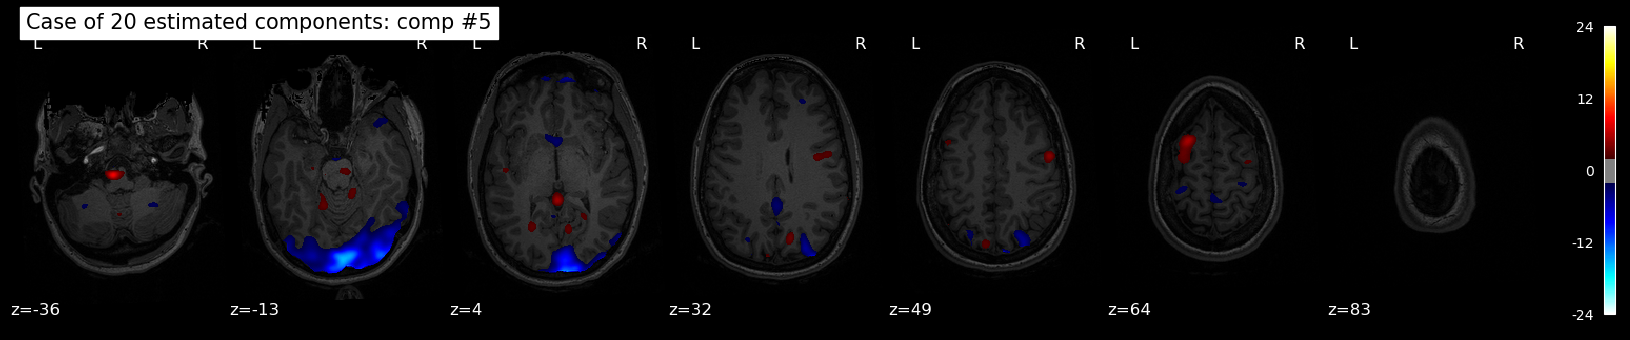

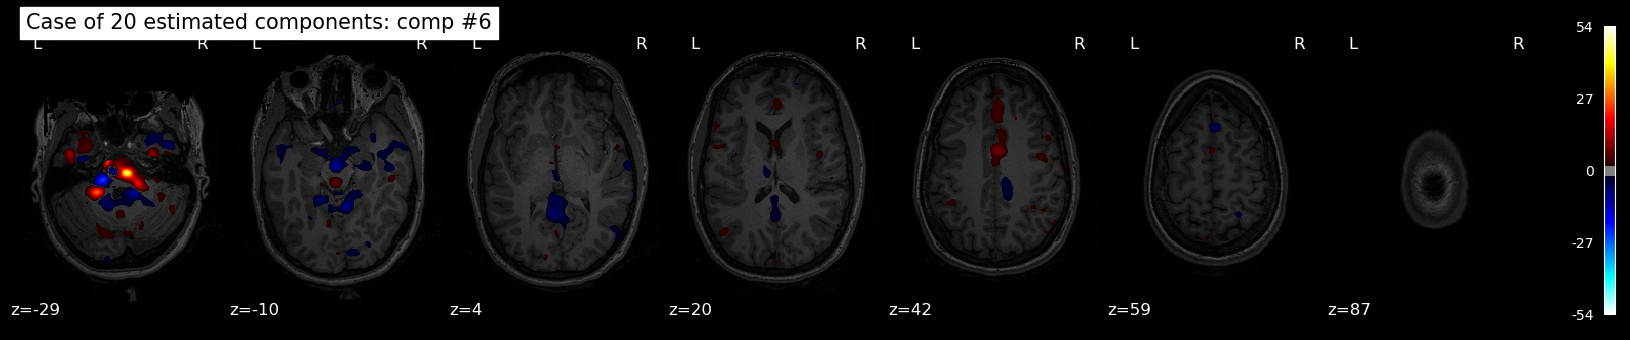

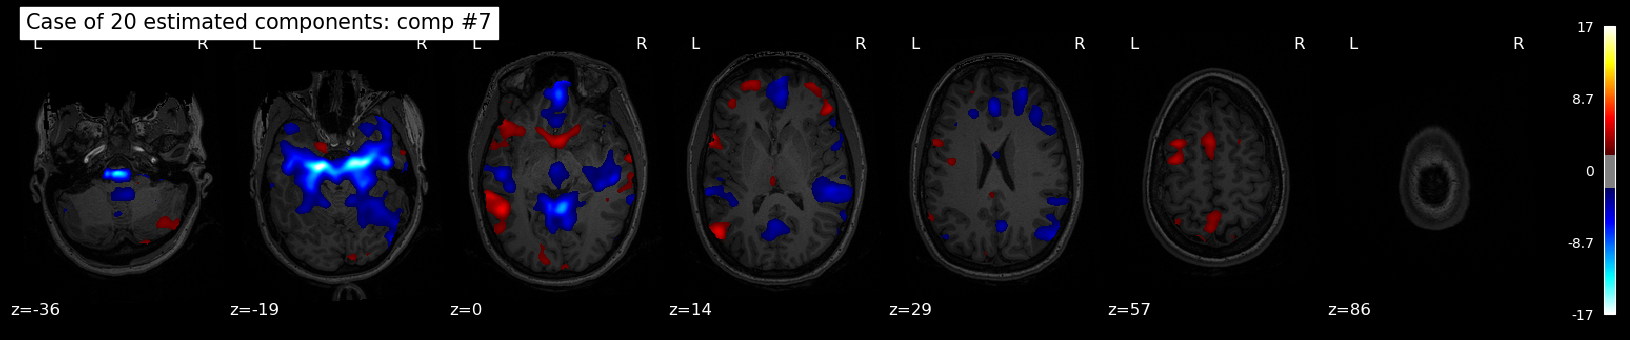

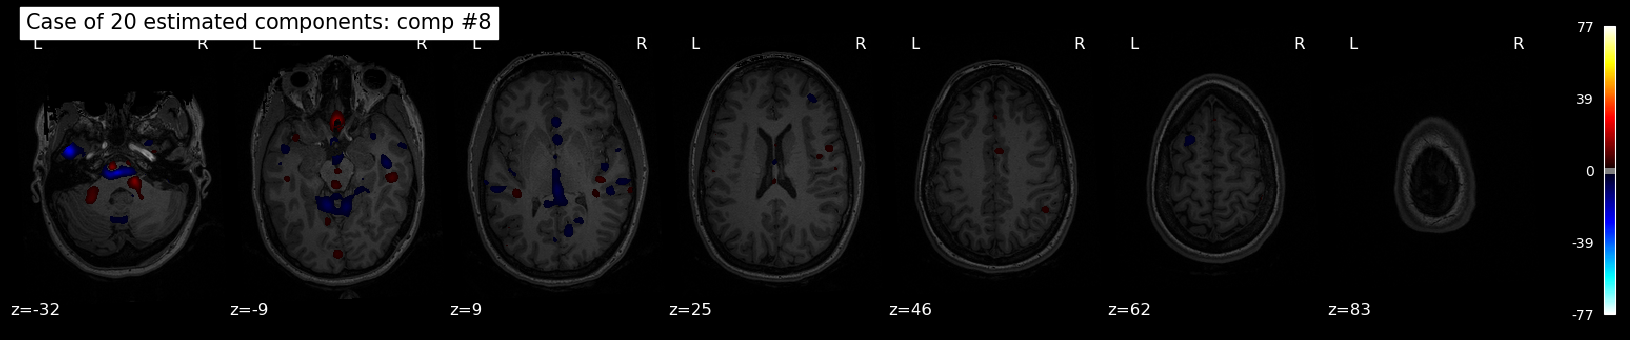

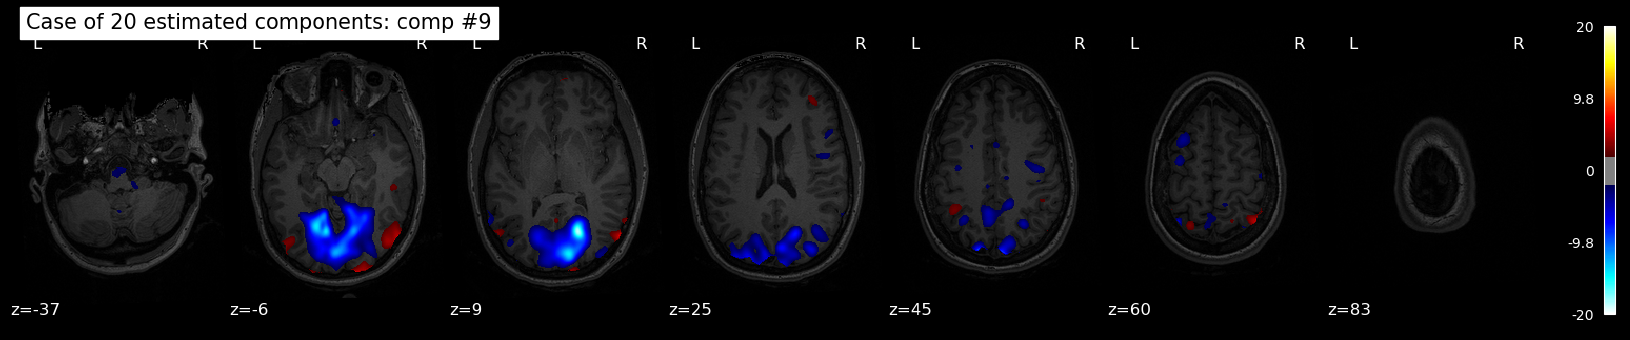

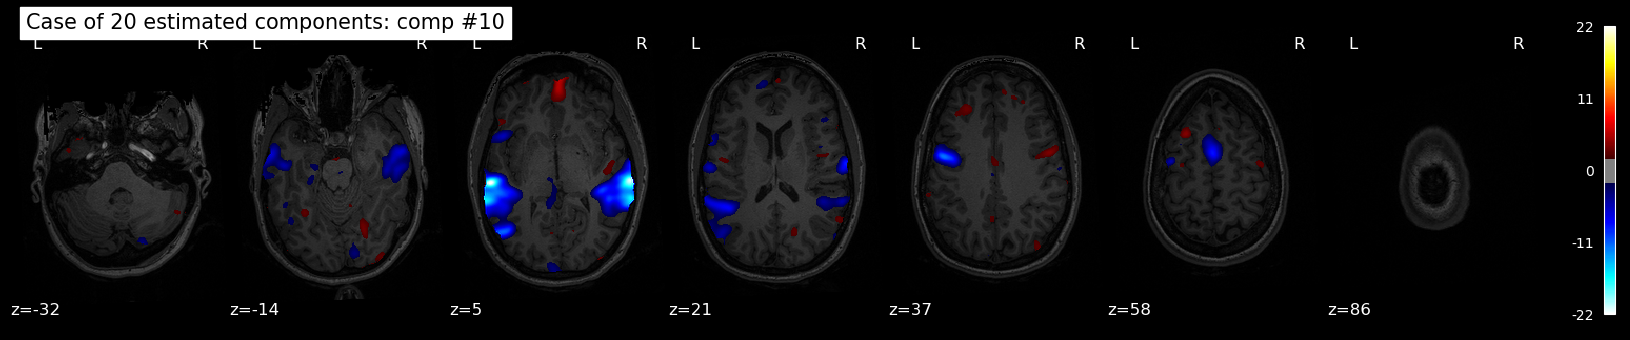

'Done all'

{20: array([[-0.10066541, -0.14188748,  0.11844574, ...,  0.04752731,
          0.20552974,  0.02816183],
        [-0.10066548, -0.14188744,  0.11844564, ...,  0.04752723,
          0.20553025,  0.02816164],
        [-0.10066548, -0.14188744,  0.11844564, ...,  0.04752723,
          0.20553025,  0.02816164],
        ...,
        [-0.10066548, -0.14188744,  0.11844564, ...,  0.04752723,
          0.20553025,  0.02816164],
        [-0.10066548, -0.14188744,  0.11844564, ...,  0.04752723,
          0.20553025,  0.02816164],
        [-0.10066548, -0.14188744,  0.11844564, ...,  0.04752723,
          0.20553025,  0.02816164]])}

In [48]:
spatial_ICA(func_path = func_name, anat_path = anat_name, ica_comp = 20, pca = True, filename = "first_20")

In [ ]:
#spatial_ICA(func_path = func_name, anat_path = anat_name, ica_comp = 20, pca = True)

# Temporal ICA

In [49]:
#Run a temporal ICA
img = nib.load(func_name)
fdata = img.get_fdata()

nb_components =  [3,]#10]#20, 60 ...]
X_ = fdata.reshape(-1, fdata.shape[-1])

T_dict = {}

for n in nb_components:
    
    H = X_.T
    
    display("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    display("size H", H.shape)
    T_ = ica.fit_transform(H)  # Get the estimated sources (S)
    display("size T", T_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    T_dict[n] = T_ # store the results in a dictionary

    display("Done Temporal ICA")

'Running FastICA with n = 3 components'

'size H'

(1028, 271633)

'size T'

(1028, 3)

'Done Temporal ICA'

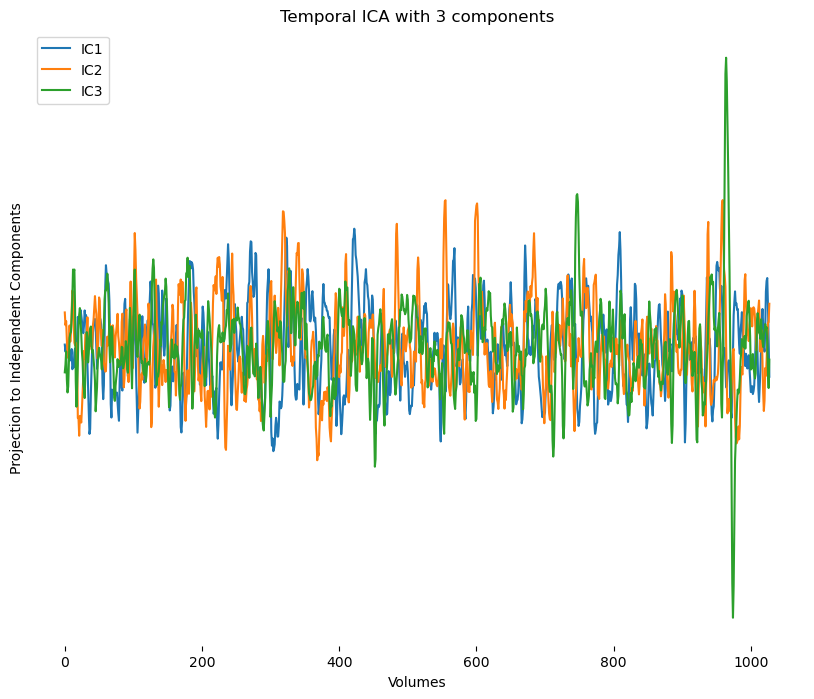

In [43]:
#Raw plot
temporal_ica = pd.DataFrame(T_dict[3])
#temporal_ica = temporal_ica.applymap(lambda x: round(x, 1)) #binning values
#temporal_ica = temporal_ica.applymap(lambda x: 0.5*x if np.abs(x) < 1 else x)
#dc_component = [7, 0, -7]
#temporal_ica = temporal_ica.apply(lambda x: x + dc_component[x.name], axis = 0)
#display(temporal_ica)
plt.figure(figsize = (10, 8))
plt.title("Temporal ICA with 3 components")
plt.plot(temporal_ica, label = [f"IC{i}" for i in range(1,4)])
plt.legend()
plt.ylabel('Projection to Independent Components')
plt.xlabel('Volumes')
plt.yticks([])
plt.box(False)
plt.show()

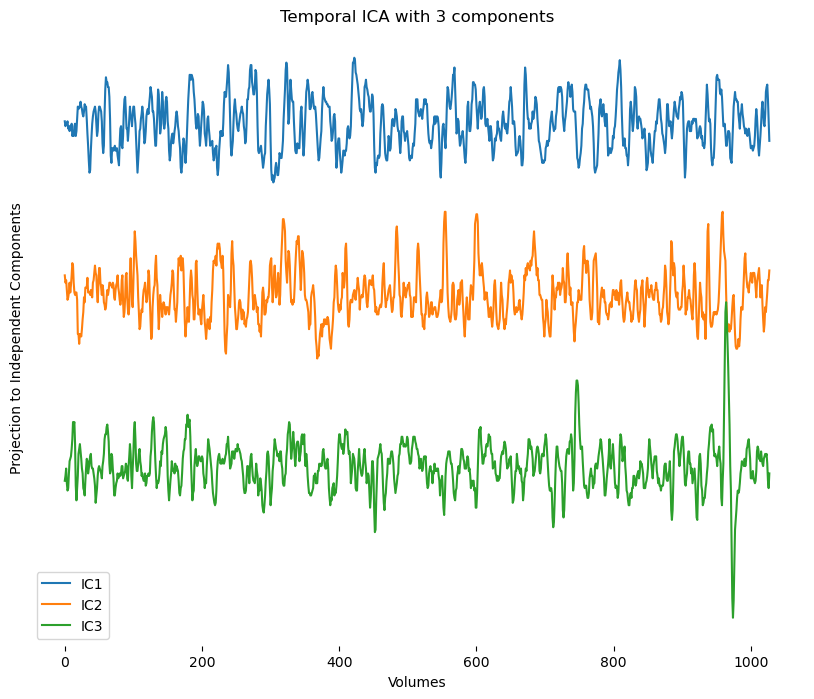

In [47]:
#separation
temporal_ica = pd.DataFrame(T_dict[3])
temporal_ica = temporal_ica.applymap(lambda x: round(x, 1)) #binning values
#temporal_ica = temporal_ica.applymap(lambda x: 0.5*x if np.abs(x) < 1 else x)
dc_component = [7, 0, -7]
temporal_ica = temporal_ica.apply(lambda x: x + dc_component[x.name], axis = 0)
#display(temporal_ica)
plt.figure(figsize = (10, 8))
plt.title("Temporal ICA with 3 components")
plt.plot(temporal_ica, label = [f"IC{i}" for i in range(1,4)])
plt.legend()
plt.ylabel('Projection to Independent Components')
plt.xlabel('Volumes')
plt.yticks([])
plt.box(False)
plt.show()

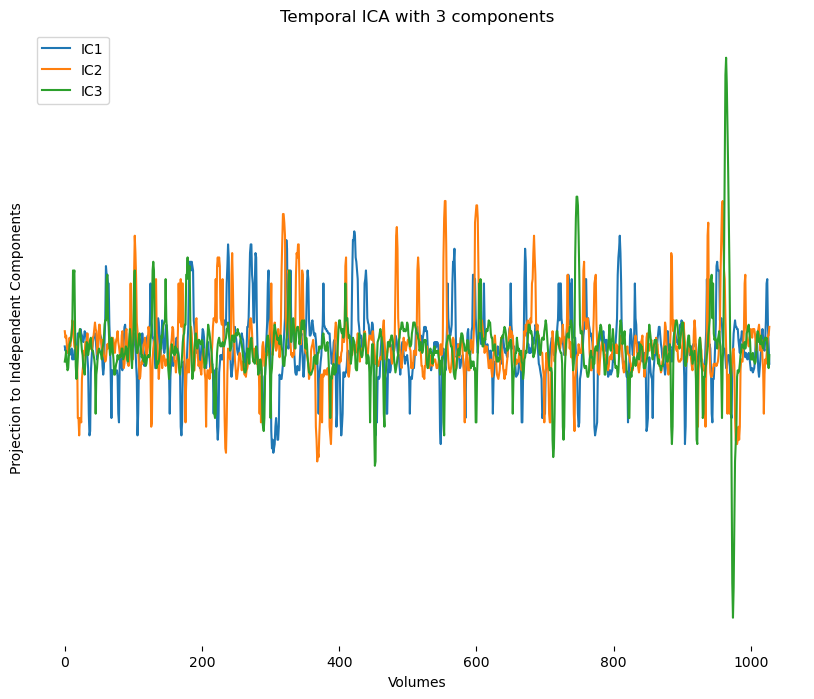

In [52]:
#noise reduction
temporal_ica = pd.DataFrame(T_dict[3])
temporal_ica = temporal_ica.applymap(lambda x: round(x, 1)) #binning values
temporal_ica = temporal_ica.applymap(lambda x: 0.5*x if np.abs(x) < 1.5 else x)
#dc_component = [7, 0, -7]
#temporal_ica = temporal_ica.apply(lambda x: x + dc_component[x.name], axis = 0)
#display(temporal_ica)
plt.figure(figsize = (10, 8))
plt.title("Temporal ICA with 3 components")
plt.plot(temporal_ica, label = [f"IC{i}" for i in range(1,4)])
plt.legend()
plt.ylabel('Projection to Independent Components')
plt.xlabel('Volumes')
plt.yticks([])
plt.box(False)
plt.show()

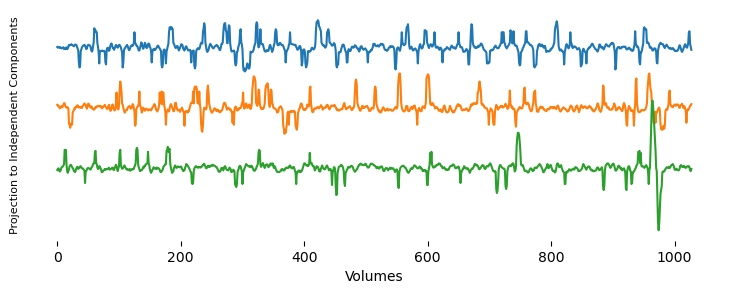

In [56]:
#noise reduction
temporal_ica = pd.DataFrame(T_dict[3])
temporal_ica = temporal_ica.applymap(lambda x: round(x, 1)) #binning values
temporal_ica = temporal_ica.applymap(lambda x: 0.35*x if np.abs(x) < 1.5 else x)
dc_component = [6, 0, -6]
temporal_ica = temporal_ica.apply(lambda x: x + dc_component[x.name], axis = 0)
#display(temporal_ica)
plt.figure(figsize = (9, 3))
#plt.title("Temporal ICA with 3 components")
plt.plot(temporal_ica, label = [f"IC{i}" for i in range(1,4)])
plt.ylabel('Projection to Independent Components', fontsize = 8)
plt.xlabel('Volumes')
plt.yticks([])
plt.box(False)
plt.savefig(f"TemporalICAFINAL.png", bbox_inches='tight', dpi = 200)
plt.show()

### Group ICA
was extremely computationally costly

In [9]:
func_name = f"sub-04_task-watchmovie_bold.nii.gz"
anat_name = "sub-04_T1w.nii.gz"
dataset_id = 'ds001145' 
subj = '04'

# Download one subject's data from each dataset
sample_path = "dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

#subject_list = [f"0{i}" for i in range(1, 10)] + ["10"]
#subject_list

In [42]:
#Careful only run once
#for subj in subject_list:
#    os.system("""openneuro-py download --dataset {} --include sub-{}/anat/sub-{}_T1w.nii.gz
#              --include sub-{}/func/sub-{}_task-watchmovie_bold.nii.gz 
#              --include dataset_description.json 
#              --target_dir {}""".format(dataset_id, subj, subj, subj, subj, bids_root).replace("\n", " "))

In [3]:
gICA = groupICA()
gICA.fit_data(func_name, bids_root, anat_name, skull = "skull.nii.gz", N_subj = 3)

'dims ='

61

73

61

1028

'nii_count:'

0

'nii_count:'

1

'nii_count:'

2

'X shape ='

(3084, 271633)

0

array([9.68103783e-01, 2.08842181e-02, 1.09730952e-02, 2.66657644e-06,
       2.12662331e-06, 1.55886727e-06, 1.48872499e-06, 1.40647746e-06])

'Explained Variance = '

0.9999703430761199

'Running FastICA with n = 4 components'

'size H'

(271633, 8)

'size S'

(271633, 4)

'Done ICA'

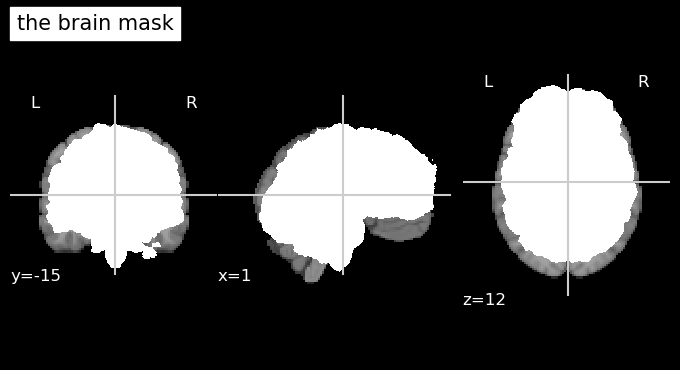

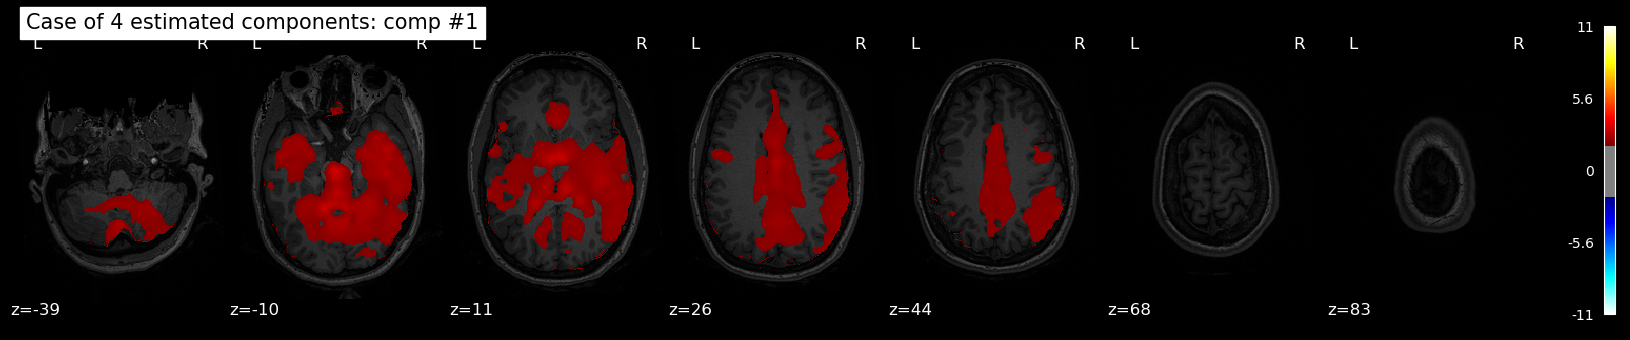

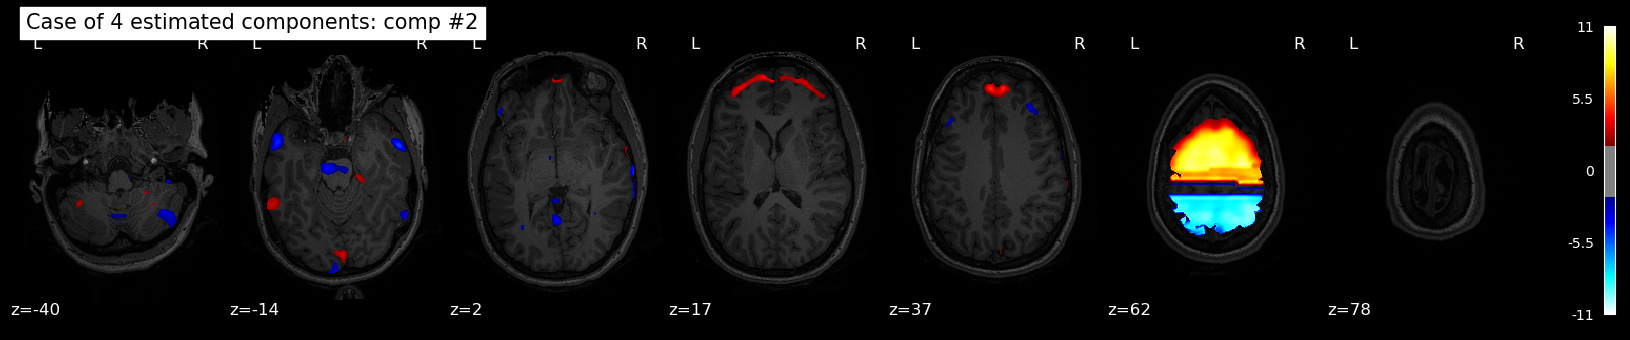

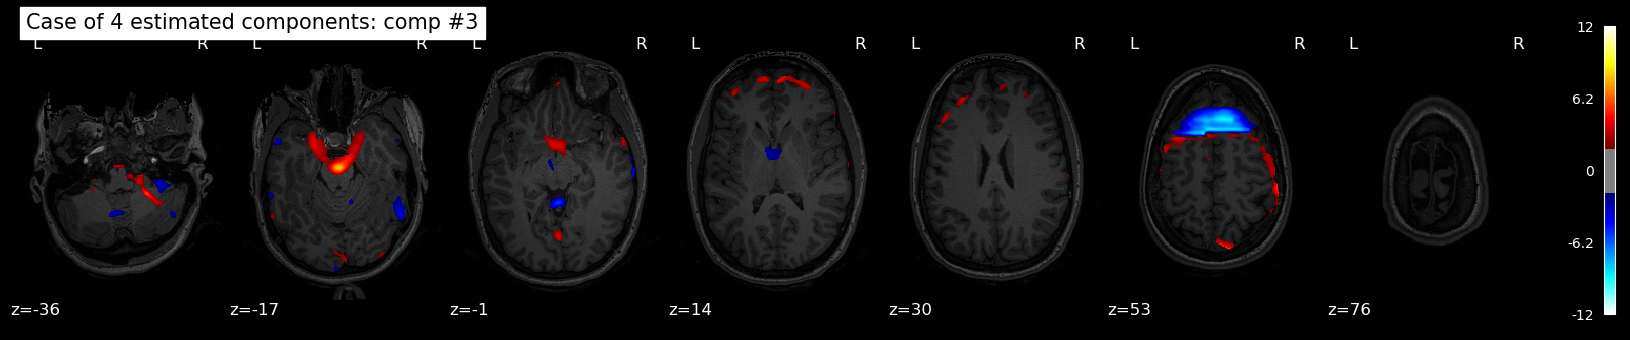

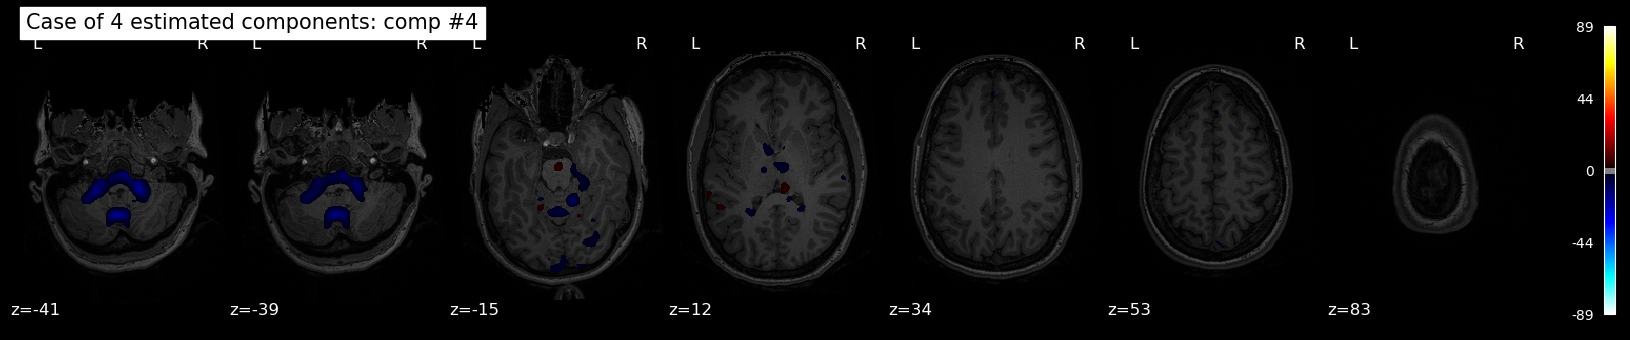

'Done all'

{4: array([[-0.57200239, -0.03508471, -0.11810464,  0.11306275],
        [-0.57200238, -0.03508471, -0.11810463,  0.11306282],
        [-0.57200238, -0.03508471, -0.11810463,  0.1130628 ],
        ...,
        [-0.57200238, -0.03508471, -0.11810463,  0.11306281],
        [-0.57200238, -0.03508471, -0.11810463,  0.11306281],
        [-0.57200238, -0.03508471, -0.11810463,  0.11306281]])}

In [4]:
gICA.execute(ica_comp = 4, pca = True, pca_comp = None, axial_plots = True, other_plots = False, type = "spatial")

### atlas code

In [21]:
oxford_atlas = datasets.fetch_atlas_harvard_oxford(atlas_name = 'cort-maxprob-thr50-2mm')
ox_data = oxford_atlas['maps'].get_fdata()

In [23]:
display(ox_data.shape,
np.unique(ox_data), oxford_atlas.keys())

(91, 109, 91)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48.])

dict_keys(['filename', 'maps', 'labels'])

In [59]:
from nilearn import datasets, plotting
from nilearn.plotting import plot_roi

aal_atlas = datasets.fetch_atlas_aal()

maps = aal_atlas.maps
labels = aal_atlas.labels
indices = aal_atlas.indices
# Plot the AAL atlas on a black background
#plot_roi(maps, title="AAL Atlas", black_bg=False, display_mode = 'ortho')

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

array([9.99968829e-01, 3.39776795e-06, 1.76236724e-06, 1.56847129e-06,
       1.40762376e-06, 1.06679636e-06, 9.97099228e-07, 8.92372992e-07])

'Explained Variance = '

0.99997992186244

'Running FastICA with n = 4 components'

'size H'

(271633, 8)

'size S'

(271633, 4)

'Done ICA'

'Done all'

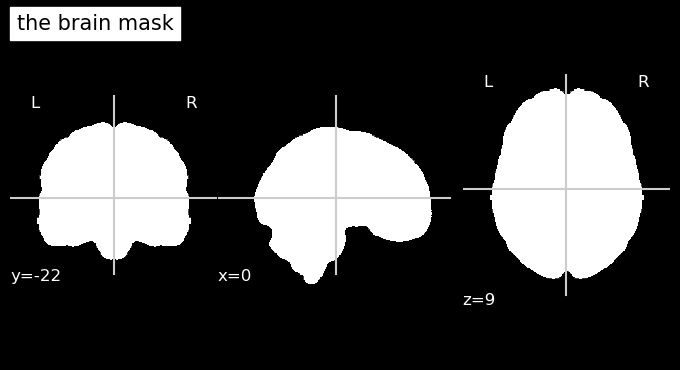

In [10]:
S_dict = spatial_ICA(func_name, anat_name, ica_comp = 4, pca = True, pca_comp = None,  axial_plots = False, other_plots = False)

In [60]:
s = S_dict[4]
s_t = np.where(np.abs(s) > 3, 1., 0.) 
maps_niimg = nib.load(aal_atlas.maps).get_fdata()
maps_affine = nib.load(aal_atlas.maps).affine
results = pd.DataFrame()
fails = []

In [63]:
for n_component in range(s_t.shape[1]):
    
    failed_indices = []
    s_img = nib.Nifti1Image(np.reshape(s_t[:,n_component], (x,y,z)), affine)
    total_component_voxels = np.sum(s_t[:, n_component])
    #s_img = resample_to_img(s_img, atlas_niimg)
    display("ica component:", n_component + 1)
    
    for j, brain_part_idx in enumerate(indices): 
        
        brain_part_map = nib.Nifti1Image(np.where(maps_niimg == float(brain_part_idx), 1., 0.), maps_affine)
        brain_part_map = resample_to_img(brain_part_map, s_img)
        atlas_masker = NiftiMasker(mask_img=brain_part_map)
        if (j%50 == 0): display("j status", j)
        try:
            data = atlas_masker.fit_transform(s_img)
            masked_ = atlas_masker.inverse_transform(data) #mask the components
            fdata = masked_.get_fdata().flatten()
            results.loc[n_component, labels[j]] = round(100*np.sum(fdata)/total_component_voxels, 1)
        except:
            failed_indices.append(j)
            continue
    fails.append(failed_indices)

'ica component:'

1

'j status'

0

'j status'

50

'j status'

100

'ica component:'

2

'j status'

0

'j status'

50

'j status'

100

'ica component:'

3

'j status'

0

'j status'

50

'j status'

100

'ica component:'

4

'j status'

0

'j status'

50

'j status'

100

In [64]:
for n_component in range(s_t.shape[1]):
    display(f"ICA component number {n_component+1} sorted brain parts in %")
    display(results.sort_values(by = n_component, axis = 1, ascending = False).T[[n_component]].T)

'ICA component number 1 sorted brain parts in %'

Temporal_Mid_L  ...  Frontal_Med_Orb_L
0            43.7  ...                0.0

[1 rows x 116 columns]

'ICA component number 2 sorted brain parts in %'

Cerebelum_Crus1_L  Cerebelum_Crus1_R  ...  Olfactory_R  Pallidum_R
1               15.7               15.2  ...          0.0        -0.0

[1 rows x 116 columns]

'ICA component number 3 sorted brain parts in %'

Occipital_Mid_L  Lingual_R  Occipital_Mid_R  ...  Heschl_L  Heschl_R  Vermis_10
2             18.5       17.8             17.7  ...       0.0      -0.0        0.0

[1 rows x 116 columns]

'ICA component number 4 sorted brain parts in %'

Frontal_Mid_R  Frontal_Mid_L  ...  Cerebelum_3_L  Vermis_10
3           27.6           14.2  ...           -0.0       -0.0

[1 rows x 116 columns]

# Oxford Atlas and graphs

In [2]:
#Run ICA and set global params
func_name = f"sub-04_task-watchmovie_bold.nii.gz"
anat_name = "sub-04_T1w.nii.gz"

img = nib.load(func_name)
affine = img.affine
fdata = img.get_fdata()
x, y, z, N_vol = fdata.shape

In [3]:
n_ica_components = 4
S_dict = spatial_ICA(func_name, anat_name, ica_comp = n_ica_components, pca = True, pca_comp = None,  axial_plots = True, other_plots = False)

'Got fdata of dimensions ='

61

73

61

1028

'X shape ='

(1028, 271633)

array([9.99968829e-01, 3.39776795e-06, 1.76236724e-06, 1.56847129e-06,
       1.40762376e-06, 1.06679639e-06, 9.97098910e-07, 8.92371501e-07])

'Explained Variance = '

0.9999799218606621

'Running FastICA with n = 4 components'

'size H'

(271633, 8)

'size S'

(271633, 4)

'Done ICA'

'Done all'

In [4]:
#Load Oxford Atlas
oxford_atlas = datasets.fetch_atlas_harvard_oxford(atlas_name = 'cort-maxprob-thr50-2mm')
atlas_niimg = oxford_atlas['maps']
atlas_fdata = atlas_niimg.get_fdata()
atlas_affine = atlas_niimg.affine
atlas_labels = oxford_atlas['labels']

In [7]:
from nilearn.image import resample_to_img
import networkx as nx

In [8]:
#Get Oxford Atlas representation
results = pd.DataFrame()
fails = []
    
s = S_dict[n_ica_components]
z_score_threshold = 3 #3 std's away from mean "safe significance" ?
s_t = np.where(np.abs(s) > z_score_threshold, 1., 0.) 

for n_component in range(s_t.shape[1]):

    failed_indices = []
    s_img = nib.Nifti1Image(np.reshape(s_t[:,n_component], (x,y,z)), affine)
    total_component_voxels = np.sum(s_t[:, n_component])
    display("ica component:", n_component + 1)

    for idx, brain_part in enumerate(atlas_labels[1:]): 
        
        brain_part_idx = idx + 1
        #display(brain_part_idx, brain_part)
        #display(np.unique(atlas_fdata))
        brain_part_map = nib.Nifti1Image(np.where(atlas_fdata == float(brain_part_idx), 1., 0.), atlas_affine)
        brain_part_map = resample_to_img(brain_part_map, s_img, interpolation ='nearest')
        atlas_masker = NiftiMasker(mask_img=brain_part_map)
        if (brain_part_idx%10 == 0): display(f"Done {brain_part_idx} brain parts")
        #try:
        data = atlas_masker.fit_transform(s_img)
        masked_ = atlas_masker.inverse_transform(data) #mask the components
        fdata = masked_.get_fdata().flatten()
        results.loc[n_component, brain_part] = round(100*np.sum(fdata)/total_component_voxels, 1)
        #except:
        #    failed_indices.append(brain_part_idx)
        #    continue
fails.append(failed_indices)

'ica component:'

1

'Done 10 brain parts'

'Done 20 brain parts'

'Done 30 brain parts'

'Done 40 brain parts'

'ica component:'

2

'Done 10 brain parts'

'Done 20 brain parts'

'Done 30 brain parts'

'Done 40 brain parts'

'ica component:'

3

'Done 10 brain parts'

'Done 20 brain parts'

'Done 30 brain parts'

'Done 40 brain parts'

'ica component:'

4

'Done 10 brain parts'

'Done 20 brain parts'

'Done 30 brain parts'

'Done 40 brain parts'

In [9]:
for n_component in range(s_t.shape[1]):
    display(f"ICA component number {n_component+1} sorted brain parts in %")
    display(results.sort_values(by = n_component, axis = 1, ascending = False).T[[n_component]].T)

'ICA component number 1 sorted brain parts in %'

Lateral Occipital Cortex, superior division  ...  Frontal Medial Cortex
0                                         10.0  ...                    0.0

[1 rows x 48 columns]

'ICA component number 2 sorted brain parts in %'

Frontal Pole  ...  Subcallosal Cortex
1           5.3  ...                 0.0

[1 rows x 48 columns]

'ICA component number 3 sorted brain parts in %'

Frontal Pole  Precuneous Cortex  ...  Paracingulate Gyrus  Occipital Pole
2           6.7                3.2  ...                  0.0             0.0

[1 rows x 48 columns]

'ICA component number 4 sorted brain parts in %'

Frontal Pole  ...  Occipital Pole
3          13.1  ...             0.0

[1 rows x 48 columns]

In [11]:
def initials(s):
    return ''.join([ss[0] if ss else ss for ss in s.split(' ')])

['FP',
 'IC',
 'SFG',
 'MFG',
 'IFGPT',
 'IFGPO',
 'PG',
 'TP',
 'STGAD',
 'STGPD',
 'MTGAD',
 'MTGPD',
 'MTGTP',
 'ITGAD',
 'ITGPD',
 'ITGTP',
 'PG',
 'SPL',
 'SGAD',
 'SGPD',
 'AG',
 'LOCSD',
 'LOCID',
 'IC',
 'FMC',
 'JLC(SMC',
 'SC',
 'PG',
 'CGAD',
 'CGPD',
 'PC',
 'CC',
 'FOC',
 'PGAD',
 'PGPD',
 'LG',
 'TFCAD',
 'TFCPD',
 'TOFC',
 'OFG',
 'FOC',
 'COC',
 'POC',
 'PP',
 'HG(HAH',
 'PT',
 'SC',
 'OP']

Index(['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus',
       'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis',
       'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
       'Temporal Pole', 'Superior Temporal Gyrus, anterior division',
       'Superior Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, anterior division',
       'Middle Temporal Gyrus, posterior division',
       'Middle Temporal Gyrus, temporooccipital part',
       'Inferior Temporal Gyrus, anterior division',
       'Inferior Temporal Gyrus, posterior division',
       'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus',
       'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division',
       'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
       'Lateral Occipital Cortex, superior division',
       'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex',
       'Frontal Medial Cortex',
       'Ju

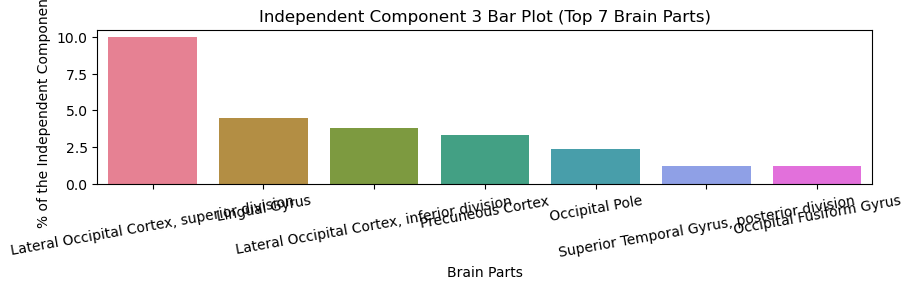

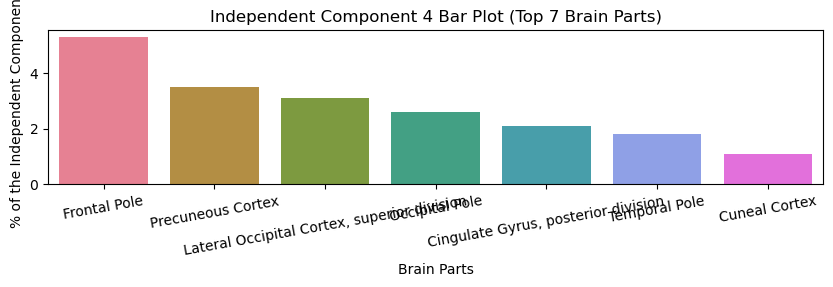

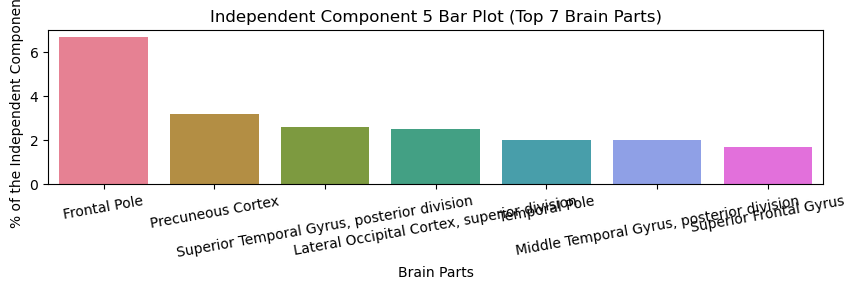

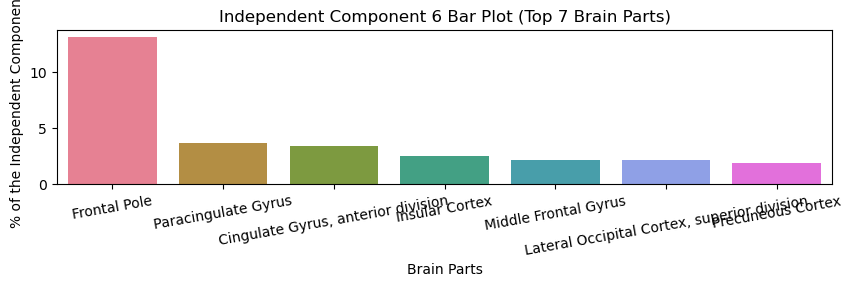

In [36]:
# Define the number of top brain parts to display
import seaborn as sns
from matplotlib import ticker

num_components = 4
top_n = 7
df = results.copy()
# Create four Seaborn bar plots for each independent component
acronyms = pd.Series(df.columns).apply(lambda bp: initials(bp).upper()).values.tolist()
#df.columns = acronyms
display(acronyms, df.columns)
for ic in range(num_components):
    # Sort brain parts by value and select the top 5
    sorted_brain_parts = pd.Series(df.iloc[ic].sort_values(ascending=False).index[:top_n])
    #tickslabels = sorted_brain_parts.apply(lambda bp: bp.split(',')[0]).values.tolist()
    #display(tickslabels)
    plt.figure(figsize=(10, 2))
    sns.barplot(data=df.loc[[ic], sorted_brain_parts], orient='v', palette='husl')
    plt.xlabel('Brain Parts')
    plt.ylabel('% of the Independent Component[')
    plt.title(f'Independent Component {ic + 3} Bar Plot (Top 7 Brain Parts)')
    plt.xticks(rotation = 10)
    #ax = plt.gca()
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    #ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    #ax.xaxis.set_minor_formatter(ticker.FixedFormatter(sorted_brain_parts))
    #ax.tick_params(axis='x', which='minor', length=20)
    #ax.tick_params(axis='x', which='both', color='lightgrey')
    #ax.autoscale(enable=True, axis='x', tight=True)

    plt.savefig(f"plot_barplotIC{ic+1}.png", bbox_inches='tight', dpi = 200)
    plt.show()

[3900.0,
 375.0,
 795.0000000000001,
 705.0,
 705.0,
 2655.0,
 734.9999999999999,
 570.0,
 555.0,
 750.0,
 1785.0,
 720.0,
 750.0]

NodeView(('Lateral Occipital Cortex, superior division', 'Lingual Gyrus', 'Lateral Occipital Cortex, inferior division', 'Precuneous Cortex', 'Occipital Pole', 'Frontal Pole', 'Cingulate Gyrus, posterior division', 'Superior Temporal Gyrus, posterior division', 'Temporal Pole', 'Paracingulate Gyrus', 'Cingulate Gyrus, anterior division', 'Insular Cortex', 'Middle Frontal Gyrus'))

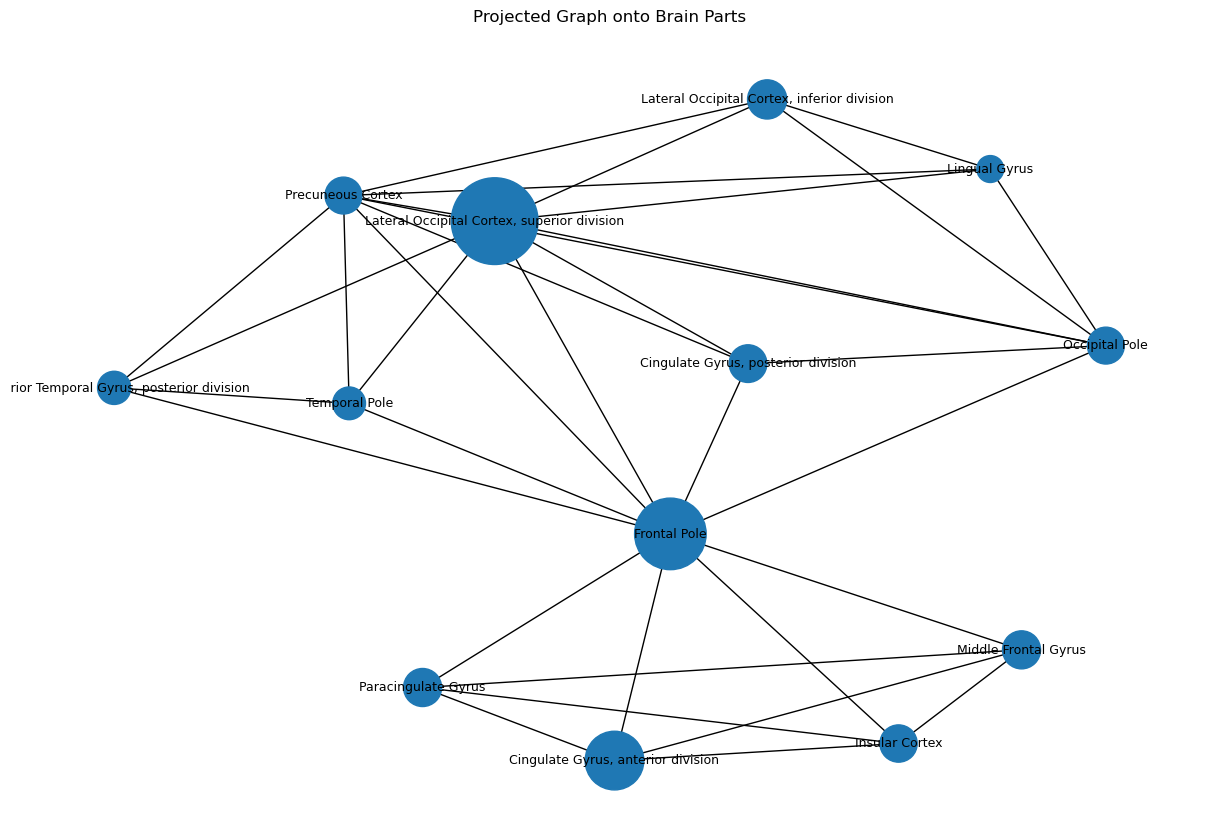

In [37]:
df = results
top_n = 5
def create_bipartite_graph(df, top_n):
    G = nx.Graph()

    for ic in df.index:
        top_brain_parts = df.loc[ic].nlargest(top_n).index
        G.add_node(ic, bipartite=0)  # Independent component
        G.add_nodes_from(top_brain_parts, bipartite=1)  # Brain parts
        for part in top_brain_parts:
            weight = df.loc[ic][part]
            G.add_edge(ic, part, weight=weight)

    return G
    
def create_projected_graph(G, nodes, bipartite):
    projected_graph = nx.bipartite.weighted_projected_graph(G, nodes, ratio=False)
    return projected_graph

def draw_projected_graph(G, df):
    pos = nx.kamada_kawai_layout(G)
    
    # Calculate the node sizes as the sum of values in the table for each component
    node_sizes = [150*df[part].sum() for part in df.columns if part in G.nodes]
    display(node_sizes)
    display(G.nodes)
    plt.figure(figsize=(12,8))
    nx.draw(G, pos, node_size = node_sizes, with_labels=True, font_size = 9)
    plt.title("Projected Graph onto Brain Parts")
    plt.savefig("graph.png", bbox_inches='tight', dpi = 200)
    plt.show()

bipartite_graph = create_bipartite_graph(df, top_n)
projected_graph = create_projected_graph(bipartite_graph, [node for node, node_data in bipartite_graph.nodes(data=True) if node_data['bipartite'] == 1], bipartite=1)
draw_projected_graph(projected_graph, df)

In [ ]:
#Make function
#vary PCA no PCA and components
#make brain mask for our T1 weighted image
#make atlas and make fit components to mask and fit correlation to different brain atlas areas
#temporal ICA